## Step One: Reading Fruit Dataset

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import random
import pickle

# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4, 1)
    train_set.append((train_set_features[i].reshape(102, 1), label))

for i in range(len(test_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4, 1)
    test_set.append((test_set_features[i].reshape(102, 1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

## Needed Functions

In [127]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def feedforward(w, a, bias, activation_func):
  z = (w @ a) + bias
  if activation_func == 'sigmoid':
    return sigmoid(z)

def cost_calculator(dataset, w1 , w2 , w3 , b1 , b2 , b3 , c):
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1 , a_0 , b1, 'sigmoid')
        a_2 = feedforward(w2 , a_1 , b2, 'sigmoid')
        a_3 = feedforward(w3 , a_2 , b3, 'sigmoid')

        for j in range(4):
            c += np.power((a_3[j, 0] - trainData[1][j,  0]), 2)
    total_costs.append(c)

def calculate_accuracy(dataset ,w1 , w2, w3, b1, b2, b3,total_num):
    correct_guesses = 0
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1 , a_0 , b1, 'sigmoid')
        a_2 = feedforward(w2 , a_1 , b2, 'sigmoid')
        a_3 = feedforward(w3 , a_2 , b3, 'sigmoid')

        predicted_label = np.argmax(a_3 , axis=0)
        real_label = np.argmax(trainData[1], axis=0)


        if predicted_label[0] == real_label[0]:
            correct_guesses  += 1
    accuracy = (correct_guesses  / total_num) * 100
    return accuracy

## Step Two: Feedforward

In [128]:
W_1 = np.random.normal(size=(150, 102))
W_2 = np.random.normal(size=(60, 150))
W_3 = np.random.normal(size=(4, 60))
b_1 = np.zeros((150, 1))
b_2 = np.zeros((60, 1))
b_3 = np.zeros((4, 1))

number_of_samples = 200
train_sample_200 = random.sample(train_set, number_of_samples)
print(f"Accuracy: {calculate_accuracy(train_sample_200 , W_1 ,W_2, W_3, b_1,b_2,b_3, number_of_samples)}")

Accuracy: 23.0


## Step Three: Backpropagation

In [129]:
%%time

batch_size = 10
learning_rate = 1
number_of_epochs = 5


def initialize():
    w1 = np.random.standard_normal(size=(150, 102))
    b1 = np.zeros((150, 1))

    w2 = np.random.standard_normal(size=(60, 150))
    b2 = np.zeros((60, 1))

    w3 = np.random.standard_normal(size=(4, 60))
    b3 = np.zeros((4, 1))

    w = [w1, w2, w3]
    bias = [b1, b2, b3]

    return w, bias

W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, number_of_samples, batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # forward propagation
            a1 = feedforward(W[0] , image , b[0], 'sigmoid')
            a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
            a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            for j in range(grad_W3.shape[0]):
                for k in range(grad_W3.shape[1]):
                    grad_W3[j, k] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j,0]) * a2[k, 0]

            for j in range(grad_b3.shape[0]):
                grad_b3[j, 0] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j,0])

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            for k in range(60):
                for j in range(4):
                    grad_a2[k, 0] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j,0]) * W[2][j, k]

            for k in range(grad_W2.shape[0]):
                for m in range(grad_W2.shape[1]):
                    grad_W2[k, m] += grad_a2[k, 0] * derivative_sigmoid(z2[k,0]) * a1[m, 0]

            for k in range(grad_b2.shape[0]):
                grad_b2[k, 0] += grad_a2[k, 0] *  derivative_sigmoid(z2[k,0])

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            for m in range(150):
                for k in range(60):
                    grad_a1[m, 0] += grad_a2[k, 0] * derivative_sigmoid(z2[k,0]) * W[1][k, m]

            for m in range(grad_W1.shape[0]):
                for v in range(grad_W1.shape[1]):
                    grad_W1[m, v] += grad_a1[m, 0] * derivative_sigmoid(z1[m,0]) * image[v, 0]

            for m in range(grad_b1.shape[0]):
                grad_b1[m, 0] += grad_a1[m, 0] * derivative_sigmoid(z1[m,0])

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))

    cost = 0
    cost_calculator(train_sample_200, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2] , cost)

CPU times: user 6min 18s, sys: 3.04 s, total: 6min 21s
Wall time: 3min 48s


Accuracy: 49.5


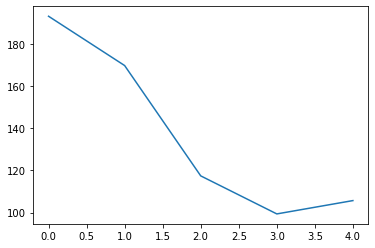

In [130]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(f"Accuracy: {calculate_accuracy(train_sample_200, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2],number_of_samples)}")

## Step Four: Vectorization

In [133]:
%%time
batch_size = 10
learning_rate = 1
number_of_epochs = 20
W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # Forward propagation
            a1 = feedforward(W[0] , image , b[0], 'sigmoid')
            a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
            a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
            grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            grad_a2 += np.transpose(W[2]) @ (2 *(a3 - label) * derivative_sigmoid(z3))
            grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
            grad_b2 += grad_a2 * derivative_sigmoid(z2)

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
            grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
            grad_b1 += grad_a1 * derivative_sigmoid(z1)

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))
    cost = 0
    cost_calculator(train_set, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2] , cost)

CPU times: user 32.8 s, sys: 575 ms, total: 33.4 s
Wall time: 21.3 s


Accuracy: 100.0


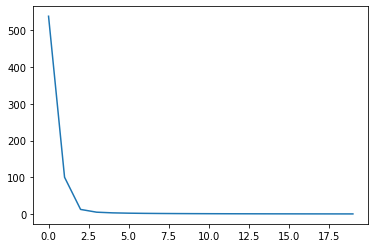

In [134]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(f"Accuracy: {calculate_accuracy(train_set, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2],len(train_set))}")

## Step Five: Testing the Model


In [137]:
%%time
batch_size = 10
learning_rate = 1
number_of_epochs = 20
W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # Forward propagation
            a1 = feedforward(W[0] , image , b[0], 'sigmoid')
            a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
            a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
            grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            grad_a2 += np.transpose(W[2]) @ (2 *(a3 - label) * derivative_sigmoid(z3))
            grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
            grad_b2 += grad_a2 * derivative_sigmoid(z2)

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
            grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
            grad_b1 += grad_a1 * derivative_sigmoid(z1)

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))
    cost = 0
    cost_calculator(train_set, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2] , cost)

CPU times: user 36 s, sys: 935 ms, total: 36.9 s
Wall time: 26.7 s


Accuracy of our model for train set is: 100.0
Accuracy of our model for test set is: 100.0


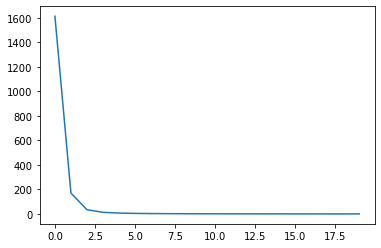

In [138]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(f"Accuracy of our model for train set is: {calculate_accuracy(train_set, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2],len(train_set))}")
print(f"Accuracy of our model for test set is: {calculate_accuracy(test_set, W[0] , W[1] , W[2] , b[0] ,b[1] , b[2],len(test_set))}")